# MNIST
- MNIST: 手書き数字を読み取るタスク
- タスクはクラス識別に分類できる
- 0~9までの数字（ラベル）があるため、10種類のクラスの中から一つのクラスを予測する

## 1. Importと定数定義

In [1]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import wandb
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [2]:
BATCH_SIZE = 256
LR = 1e-3
NUM_WORKERS = 4
EPOCHS = 20

## 2. Datasetsを読み込む

In [3]:
# 学習用データセット
train_datasets = datasets.MNIST(
    "data/",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0],
            std=[1],
        ),
    ])
)
# 検証用データセット
val_datasets = datasets.MNIST(
    "data/",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0],
            std=[1],
        ),
    ])
)

## 3. Modelの用意

In [4]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),            
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(128, 512, kernel_size=3),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),            
        )
        self.fc1 = nn.Linear(
            12 * 12 * 512,
            64
        )
        self.fc2 = nn.Linear(
            64,
            10
        )
        self.activation = nn.LogSoftmax(dim=1)
        
    def forward(self, x: torch.Tensor):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view((-1, 12 * 12 * 512))
        x = self.fc1(x)
        x = self.fc2(x)
        out = self.activation(x)
        return out

### ネットワークの確認（任意）
今回MNISTは28×28pxなので同様の形状でネットワークに入力をして、出力が(BATCH_SIZE, 10)の形状のテンソルであることを確認する

In [5]:
# torch.randは[0, 1)で値を返すので255で掛け算する
input_image, input_label = train_datasets[100]
input_image.shape

torch.Size([1, 28, 28])

In [6]:
input_label = torch.tensor([input_label])

In [7]:
imgs = input_image.unsqueeze(dim=0)
labels = input_label.unsqueeze(dim=0)
model = Model()
outs = model(imgs)
outs

tensor([[-2.6231, -2.2242, -2.1726, -2.5278, -2.1947, -2.1921, -2.3536, -2.2326,
         -2.1559, -2.4723]], grad_fn=<LogSoftmaxBackward0>)

nn.Softmaxの出力は各ラベルの確率なので合計すると1になる

In [8]:
torch.sum(outs)

tensor(-23.1488, grad_fn=<SumBackward0>)

学習をしていない状態での予測結果を確認

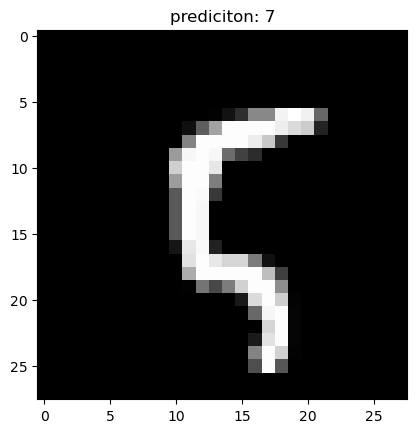

In [19]:
predict_label = torch.argmax(outs, dim=1)[0].item()
img = input_image.permute((1, 2, 0)).numpy()
plt.imshow(img, cmap="gray")
plt.title(f"prediciton: {predict_label}")
plt.show()

## 4.学習 & 検証

### 学習に必要な要素の準備

In [10]:
# デバイス
device = torch.device("cuda")

# 深層学習モデル
model = Model()
model = nn.DataParallel(model)
model = model.to(device)

# 損失関数
loss_fn = nn.NLLLoss() # nn.LogSoftmax + nn.NLLLoss == 交差クロスエントロピー

# 最適化関数
optimizer = optim.Adam(model.parameters(), lr=LR)

# データローダ
# 学習用
train_dataloader = DataLoader(
    train_datasets,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
)
# 検証用
val_dataloader = DataLoader(
    val_datasets,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
)

### 学習 & 検証

In [11]:
results = [
    {
        "train": {},
        "val": {}
    } for i in range(EPOCHS)
]

In [12]:
for epoch in tqdm(range(EPOCHS)):
    model.train()
    epoch_loss = 0
    correct_counts = 0
    for imgs, labels in tqdm(train_dataloader, leave=False):        
        optimizer.zero_grad()
        imgs = imgs.to(device)
        labels = labels.to(device)
        outs = model(imgs)
        loss = loss_fn(outs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()    
        preds = torch.argmax(outs, dim=1)
        correct_counts += (preds == labels).sum().item()
    acc = correct_counts / len(train_datasets)
    print(f"epoch: {epoch}, train loss: {epoch_loss:.3f}. train acc: {acc:.3f}")
    results[epoch]["train"]["acc"] = acc
    results[epoch]["train"]["loss"] = epoch_loss
    with torch.no_grad():
        model.eval()
        correct_counts = 0
        for imgs, labels in tqdm(val_dataloader, leave=False):
            imgs = imgs.to(device)
            labels = labels.to(device)
            outs = model(imgs)
            preds = torch.argmax(outs, dim=1)
            correct_counts += (preds == labels).sum().item()
        acc = correct_counts / len(val_datasets)
        print(f"epoch: {epoch}, val acc: {acc:.3f}")
        results[epoch]["val"]["acc"] = acc

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0, train loss: 154.601. train acc: 0.928


  5%|▌         | 1/20 [00:15<04:58, 15.73s/it]

epoch: 0, val acc: 0.971


epoch: 1, train loss: 36.665. train acc: 0.973


 10%|█         | 2/20 [00:21<02:58,  9.92s/it]

epoch: 1, val acc: 0.976


epoch: 2, train loss: 21.131. train acc: 0.981


 15%|█▌        | 3/20 [00:27<02:17,  8.07s/it]

epoch: 2, val acc: 0.981


epoch: 3, train loss: 13.181. train acc: 0.987


 20%|██        | 4/20 [00:33<01:54,  7.18s/it]

epoch: 3, val acc: 0.986


epoch: 4, train loss: 9.855. train acc: 0.989


 25%|██▌       | 5/20 [00:39<01:40,  6.71s/it]

epoch: 4, val acc: 0.987


epoch: 5, train loss: 6.418. train acc: 0.992


 30%|███       | 6/20 [00:44<01:29,  6.41s/it]

epoch: 5, val acc: 0.987


epoch: 6, train loss: 5.979. train acc: 0.993


 35%|███▌      | 7/20 [00:50<01:20,  6.23s/it]

epoch: 6, val acc: 0.986


epoch: 7, train loss: 4.128. train acc: 0.994


 40%|████      | 8/20 [00:56<01:13,  6.12s/it]

epoch: 7, val acc: 0.984


epoch: 8, train loss: 4.389. train acc: 0.994


 45%|████▌     | 9/20 [01:02<01:06,  6.04s/it]

epoch: 8, val acc: 0.985


epoch: 9, train loss: 4.112. train acc: 0.995


 50%|█████     | 10/20 [01:08<00:59,  5.98s/it]

epoch: 9, val acc: 0.984


epoch: 10, train loss: 2.953. train acc: 0.996


 55%|█████▌    | 11/20 [01:14<00:53,  5.96s/it]

epoch: 10, val acc: 0.984


epoch: 11, train loss: 4.534. train acc: 0.994


 60%|██████    | 12/20 [01:20<00:47,  5.94s/it]

epoch: 11, val acc: 0.986


epoch: 12, train loss: 4.154. train acc: 0.995


 65%|██████▌   | 13/20 [01:26<00:41,  5.91s/it]

epoch: 12, val acc: 0.986


epoch: 13, train loss: 3.636. train acc: 0.995


 70%|███████   | 14/20 [01:31<00:35,  5.90s/it]

epoch: 13, val acc: 0.988


epoch: 14, train loss: 2.374. train acc: 0.996


 75%|███████▌  | 15/20 [01:37<00:29,  5.88s/it]

epoch: 14, val acc: 0.987


epoch: 15, train loss: 2.740. train acc: 0.997


 80%|████████  | 16/20 [01:43<00:23,  5.86s/it]

epoch: 15, val acc: 0.987


epoch: 16, train loss: 2.317. train acc: 0.997


 85%|████████▌ | 17/20 [01:49<00:17,  5.86s/it]

epoch: 16, val acc: 0.986


epoch: 17, train loss: 2.371. train acc: 0.997


 90%|█████████ | 18/20 [01:55<00:11,  5.89s/it]

epoch: 17, val acc: 0.987


epoch: 18, train loss: 2.629. train acc: 0.997


 95%|█████████▌| 19/20 [02:01<00:05,  5.88s/it]

epoch: 18, val acc: 0.988


epoch: 19, train loss: 2.873. train acc: 0.996


100%|██████████| 20/20 [02:07<00:00,  6.36s/it]

epoch: 19, val acc: 0.986


# 5.可視化

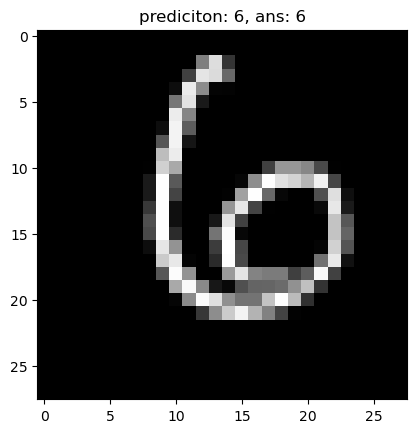

In [25]:
img, label = val_datasets[100]
outs = model(img.unsqueeze(dim=0))

predict_label = torch.argmax(outs, dim=1)[0].item()
img = img.permute((1, 2, 0)).numpy()
plt.imshow(img, cmap="gray")
plt.title(f"prediciton: {predict_label}, ans: {label}")
plt.show()

In [13]:
train_acc = []
train_loss = []
val_acc = []
for result in results:
    train_acc.append(result["train"]["acc"])
    train_loss.append(result["train"]["loss"])
    val_acc.append(result["val"]["acc"])

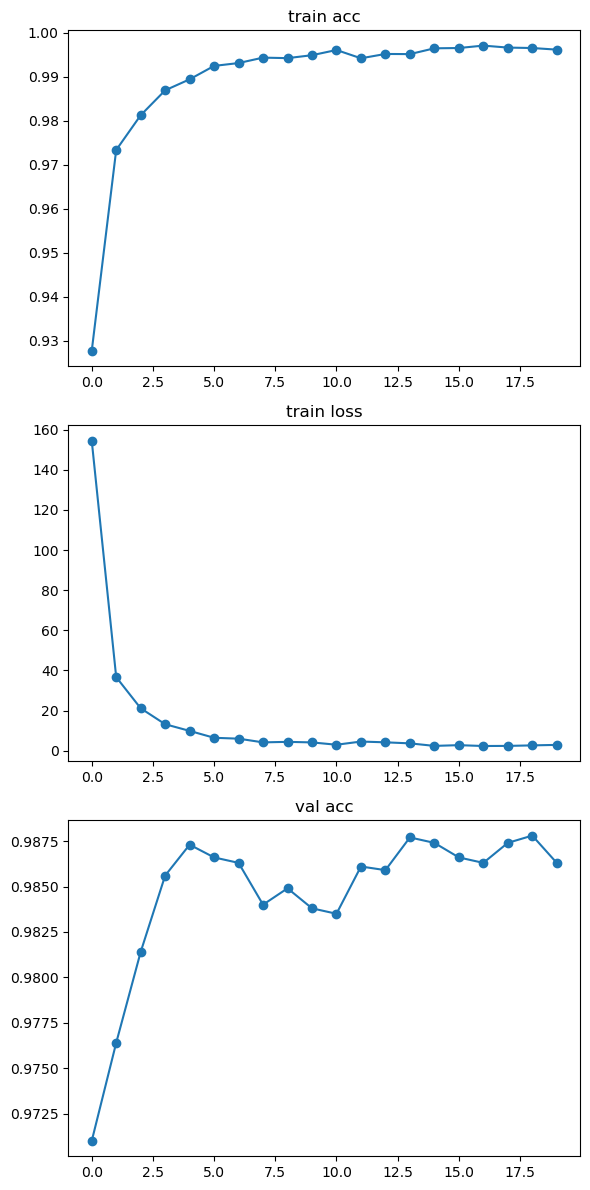

In [14]:
x = np.array(range(EPOCHS))
fig, axes = plt.subplots(3, 1, figsize=(6, 12))

axes[0].plot(x, train_acc, marker="o")
axes[0].set_title("train acc")
axes[1].plot(x, train_loss, marker="o")
axes[1].set_title("train loss")
axes[2].plot(x, val_acc, marker="o")
axes[2].set_title("val acc")
fig.tight_layout()
fig.show()